In [ ]:
#Import packages. Feel free to add any others you might use!
import itertools
import jax.numpy as jnp
import matplotlib.pyplot as plt
from jax import random as jrandom
from jax import nn as jnn
import numpy as np
import random
import time
import math

# Project 2
#### Markov Decision Processes and Reinforcement Learning (MATH 4060)

In this project we find the optimal strategy of the game *Pig* against an optimal player using value iteration, and against a specific player using SARSA.

# Problem 1 - Optimal Strategy in 2 Player Pig

## 1a Solution

Consider the state space where $\mathcal{S} = \{(r, n, m, p_i) : r, n, m\in\mathbb{N}, i\in[1, 2]\}$. Where $p_i$ is the **current player**, $r$ is the amount of spaces the runner has advanced, $n$ is **player 1**'s distance from the target, $m$ is **player 2**'s distance from the target, and $k$ is the **current player**'s runner location. In two player Pig the player's only have two actions. The player can either **roll** or **stay**, so $\mathcal{A} = \{\text{roll}, \text{stay}\}$. The player will only receive a reward when the player chooses the **stay**. So our reward space will be

\begin{align*}
  \mathcal{R_t} =
  \begin{cases}
    1, \text{if win} \\
    0, \text{if lose} \\
  \end{cases}
\end{align*}

Let $d$ be a random number in the interval $[1, 6]$, each number has probability $\frac{1}{6}$ of appearing. The state transition probability for player one are given by the following:

\begin{align}
  \text{From } (r, n, m, p_1) \text{ with } p_1 \text{ rolling } & \rightarrow
  \begin{cases}
    (r + d, n, m, p_1) &\text{ if $d \gt 1$ } \\
    (0, n, m, p_2) &\text{ if $d = 1$ } \\
  \end{cases} \\
  \text{From } (r, n, m, p_1) \text{ with } p_1 \text{ staying } & \rightarrow (0,n-r,m, p_2) \text{ with probability 1}
\end{align}

And the state transition probability for player two are given by the following:
\begin{align}
  \text{From } (r, n, m, p_2) \text{ with } p_2 \text{ rolling }& \rightarrow
  \begin{cases}
    (r + d, n, m, p_2) &\text{ if $d \gt 1$ } \\
    (0, n, m, p_1) &\text{ if $d = 1$ } \\
  \end{cases} \\
  \text{From } (r, n, m, p_2) \text{ with } p_2 \text{ staying } & \rightarrow (0,n,m-r, p_1) \text{ with probability 1}
\end{align}

The game starts in state $(0, n, m, p_1)$ with $n = m = N_{max}$ where $N_{max}$ is the **target score**. Note that player's win when the distance to the **target score** is less than or equal to $0$. Therefore, the following states are terminal states:

\begin{align}
  (0, 0, m, p_2), \forall m > 0 \iff \text{player 1 wins}\\
  (0, n, 0, p_1), \forall n > 0 \iff \text{player 2 wins}
\end{align}

**Note:** The state $(0, 0, 0, p_i)$ will never be reached since both players can't win.

## 1b Solution

If both players are playing optimally in a 2 player game of *Pig*, and $p$ is the probability that **player 1** will win the game. Then, the probability that **player 2** will win the game is $1-p$. We can utilize this symmetry to simplify our state space. Rather than thinking about **player 1** and **player 2** we can think about **current player** and **opponent**. Then our state space simplifies to $\mathcal{S} = \{(r,n,m) : r,n,m\in [0, N_{max}]\}$. Where $r$ is the amount of spaces the runner has advances, $n$ is the **current player**'s distance from the target, $m$ is the **opponent**'s distance from the target and $N_{max}$ is the maximum distance from the target. Now, rather than switching between **player 1** and **player 2** we can instead just switch $n$ and $m$. **Note** that this only works because both player's are playing optimally. In other words, if player's are in the same state (with $n$ and $m$ switched) their decisions should be identical.

The rewards will be the same as before.

Let $d$ be a random number in the interval $[1, 6]$, each number has probability $\frac{1}{6}$ of appearing. Then, the transition probabilities are as follows:

\begin{align}
  \text{From } (r, n, m) \text{ with rolling } & \rightarrow
  \begin{cases}
    (r + d, n, m) &\text{ if } d \gt 1\\
    (0, m, n) &\text{ if } d = 1 \\
  \end{cases} \\
  \text{From } (r, n, m) \text{ with player staying } & \rightarrow (0,m,n-r) \text{ with probability 1}
\end{align}

The game will now start in state $(0, N_{max}, N_{max})$. Note that player's win when the distance to the **target score** is less than or equal to $0$. Therefore, the following states are terminal states:

\begin{align}
  (0, 0, m), \forall m > 0 &\iff \text{current player wins}\\
  (0, n, 0), \forall n > 0 &\iff \text{opponent wins}\\
\end{align}

**Note:** The state $(0, 0, 0)$ will never be reached since both players can't win.

## 1c Solution

We will perform value iteration to find the optimal strategy for this game. First, we need to initialize the known values in our value function. The value function is the probability we will win if we play the optimal policy in any given state. So the only information we know is that we will win if we choose to stay when our runner position is greater than or equal to our distance from the target. So we can set these states to 1 in our value function. Then, we run the value iteration algorithm over the state space.

If we choose to **roll again**, two things can happen. We either bust, or we advance. The value in the case that we bust is the probability that the opponent loses. By the symmetry described in part 1b, the probability that the opponent loses is $1 - V_{k-1}[0, m, n]$. If we do not bust, our runner will advance $2$ to $6$ squares each with probability $0.2$ (In code is described by a transition matrix). So our update equation for value iteration when we choose to **roll again** is:

\begin{align*}
  Q_k[r, n, m, \text{roll again}] = &\frac{1}{6}(1-V_{k-1}[0, m, n]) + \frac{5}{6}(\sum_{i=2}^6\frac{1}{5}V_{k-1}[r+i,n,m]) \tag{1}
\end{align*}

If we choose to **stay**. We either win, or we give the opponent a chance to advance, bust, or win. So the value when we stay is either $1$ when $r \ge n$, or it is the probability the opponent loses given that we advanced our runner by $r$. That is $1-V_{k-1}[0, m, n-r]$. So our update equation for value iteration when we choose to **stay** is:

\begin{align*}
  Q_k[r, n, m, \text{stay}] =
  \begin{cases}
    1 & \text{ if $r \ge n$} \\
    1 - V_{k-1}[0, m, n - r] & \text{ if $r < n$}
  \end{cases} \tag{2}
\end{align*}

Then we calculate the value function by choosing the maximum over the actions.

\begin{align*}
  V_k[r,n,m] = \max(Q_k[r, n, m, \text{roll again}], Q_k[r, n, m, \text{stay}]) \tag{3}
\end{align*}

As we run value iteration, the value function and Q function will approach the optimal policy.

\begin{align*}
  \lim_{k → ∞}Q_k[r,n,m,a] &= q_*[r,n,m,a] \\
  \lim_{k → ∞}V_k[r,n,m] &= v_*[r,n,m]
\end{align*}

In [ ]:
def visualizeMatrix(M): 
  '''Visualize a matrix as a plot including the scale'''
  #Input:
  # M = matrix to visualize
  
  fig = plt.figure()
  ax = fig.add_subplot(111)
  cax = ax.matshow(M, interpolation='nearest')
  fig.colorbar(cax)

  plt.show()

In [ ]:
def pig_matrix(N_max):
  #Matrix of movement transition probabilities matrix
  #Input:
  # N_max = Maximum distance that a player can advance their runners in a single turn.
  #Output:
  # P = the pig matrix
  #for the runner locations in PIG on a reroll
  # -Assumes there is no bust (i.e. assuming you advance!)
  # -Capped at N_max (so you can't exceed runners past N_max) for the pruposes of simulation
  P = np.zeros((N_max+1,N_max+1))
  i,j = np.indices(P.shape)
  one_fifth = 1.0/5.0

  # assign the advance probabilities along the diagonal
  for k in np.arange(2,7):
     P[i+k==j] = one_fifth

  #Make the last column larger so that each row sums to 1
  #This is effectively "rounding down" anything that goes over S_max 
  row_sums = np.sum(P,axis=1)
  P[:,N_max] += 1-row_sums

  return P

def init_2_player_pig_value_func(N_max):
  '''Initializes the 2 player PIG value function'''
  #Input:
  # N_max = Maximum distance that players can ever be from the finish line
  #Output:
  # q_stay = an array of shape N_max+1, N_max+1, N_max+1 with probability to win from a state if we choose to stay
  # q_roll_again = an array of shape N_max+1, N_max+1, N_max+1 with probability to win from a state if we choose to roll again
  # v_star  = an array of shape N_max+1, N_max+1, N_max+1 with probability to win from given state
  # Note: The state space indexing is as following: [r, n, m]
  #   r = how far the runner has advanced
  #   n = distance remaining for the play
  #   m = distance remaining for the opponent

  # initialize all values to zero
  q_stay = np.zeros((N_max+1, N_max+1, N_max+1))
  q_roll_again = np.zeros(q_stay.shape)

  r,n,m = np.indices(q_stay.shape)

  # if the runner has more than or equal to the remaining squares
  # we win if we choose stay
  q_stay[r >= n] = 1

  # choose action with maximum value
  v_star = np.maximum(q_stay, q_roll_again)

  return q_stay, q_roll_again, v_star

def optimal_2_player_pig(N_max, n_iter=100):
  '''Computes the optimal strategy in 2 player PIG for games up to size N_max'''
  #Input: 
  #   N_max = Maximum distance that players can ever be from the finish line
  #   n_iter = number of iterations, by default 100
  #Output:
  # v_star, roll_again
  # v_star = An array of shape N_max,N_max,N_max with the probabability to win from a given position
  # roll_again =An array of shape N_max,N_max,N_max with whether or not to roll again from a given position
  # Note: The state space indexing is as following: [r, n, m]
  #   r = how far the runner has advanced
  #   n = distance remaining for the play
  #   m = distance remaining for the opponent

  # initialize value function, pig matrix, and bust probability
  q_stay, q_roll_again, v_star = init_2_player_pig_value_func(N_max)
  P = pig_matrix(N_max)
  p_bust = 1.0/6.0
  
  # value iterate n_iter times
  for i in np.arange(n_iter):
    if i % int(n_iter/10) == 0:
      print("iter # :", i)
    for n in np.arange(N_max+1):
      for m in np.arange(N_max+1):

        # the value when we bust is the value of the opponent losing
        bust_value = 1-v_star[0,m,n]

        # we update the value of roll again as in equation (1)
        q_roll_again[:,n,m] = p_bust*bust_value + (1-p_bust)*np.einsum('i,si', v_star[:, n, m], P)

        # we update the value of stay as in equation (2)
        q_stay[:n, n, m] = 1 - v_star[0, m, n - np.arange(0,n)]

        # choose maximum value between actions as in equation (3)
        v_star[:, n, m] = np.maximum(q_stay[:, n, m], q_roll_again[:, n, m])

  return v_star, q_roll_again > q_stay

## Problem 1 - Tests and Notes
Just some tests I ran while working on this problem and some observations.

In [ ]:
# tests to check if the value function makes sense
def test_optimal_2_player_pig_value_function(v_star, N_max):
  # The probability to win should always be strictly 
  # less as the opponent approaches the target.
  # * except when n or m are 2 or 1, these should be the same.
  for n in np.arange(N_max, 2, -1):
    for m in np.arange(N_max, 2, -1):
      for j in np.arange(m - 1, -1, -1):
        assert(v_star[0, n, m] > v_star[0, n, j])

  # when n = 2 it should be the same probability to win as when n = 1
  # when m = 2 it should be the same probability to win as when m = 1
  # regardless of the m or n respectively
  assert(np.all(v_star[0, 2, :] == v_star[0, 1, :]))
  assert(np.all(v_star[0, :, 2] == v_star[0, :, 1]))

  # at the initial position the player who goes first should have a higher chance to win.
  assert(v_star[0, N_max, N_max] > 0.50)

  # if r >= n, we are guaranteed to win.
  r,n,m = np.indices(v_star.shape)
  assert(np.all(v_star[r >= n] == 1))

  assert(np.all(v_star[r, n, m]))

  print("All tests passed")

With 100 iterations of value iteration and a target score of 100

Some observations:
* When both players have similar scores and are both far away from the target the optimal strategy is to play the **stop at 20 strategy**.
* When the opponent is ahead the optimal strategy is more risky play.
* When the opponent is behind the optimal strategy is to be more passive.
* When both players are at the initial position, the player who goes first has a slightly higher chance to win, $P_{0, 100, 100} = 0.5308$.
* When the opponent starts with a 4 point lead the game is almost fair, $P_{0, 100, 96} = 0.5015$.
* When the opponent is 16 squares from the target, the player should roll until they win.
* There is a wave that goes along the main diagonal - some of these states seem to be impossible to reach when playing the optimal strategy.

In [ ]:
# this will take about 50 seconds
v_star, roll_again = optimal_2_player_pig(100, 100)

iter # : 0
iter # : 10
iter # : 20
iter # : 30
iter # : 40
iter # : 50
iter # : 60
iter # : 70
iter # : 80
iter # : 90


Probability to win at initial position:  0.5308243426397838
Probability to win when opponent has a 4 point lead:  0.5014523989563842

Plot of the roll again matrix when the opponent is at 100


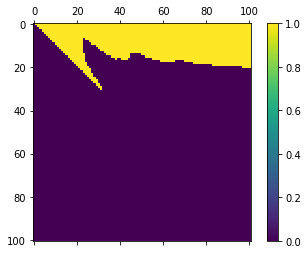

Plot of the roll again matrix when the opponent is at 50


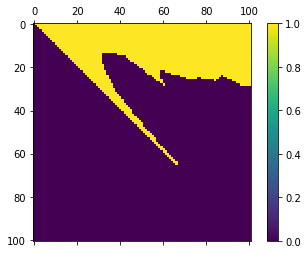

Plot of the roll again matrix when the opponent is at 16


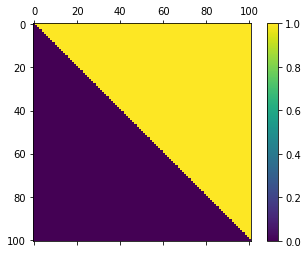

All tests passed


In [ ]:
# this works given that N_max = 100 and n_iter = 100

print("Probability to win at initial position: ", v_star[0, 100, 100])
print("Probability to win when opponent has a 4 point lead: ", v_star[0, 100, 96])

print("\nPlot of the roll again matrix when the opponent is at 100")
visualizeMatrix(roll_again[:, :, 100])

print("Plot of the roll again matrix when the opponent is at 50")
visualizeMatrix(roll_again[:, :, 50])

print("Plot of the roll again matrix when the opponent is at 16")
visualizeMatrix(roll_again[:, :, 16])

test_optimal_2_player_pig_value_function(v_star, 100)

# Problem 2 - Playing PIG against the enemy

## 2a Solution


Here we will use SARSA to determine the optimal policy against a given opponent. SARSA is an *on-policy* learning algorithm, meaning it updates a policy based on an action taken. So, we need to have a model of the environment that takes in a state and an action and gives us back a new state. 

The states are in the form $(r, p_1, p_2)$ where $r$ is the position of the runner, $p_1$ is the distance that the player is away from the target, and $p_2$ is the distance that the opponent is away from the target.

We have two actions that we can perform **Roll again** and **Stay**. If we perform an action that causes our turn to end, we will simulate the opponent turn immediately so that when we are given a new state it is always our turn.

**Case 1:** If we choose action **stay** and the current state is $(r, p_1, p_2)$ we go to the state $(0, p_1 - r, l)$. Note that we need to restrict $p_1 - r$ so that it is never negative. Where $l$ is the new distance that the enemy is away from the target after their turn.

**Case 2:** If we choose action **roll again**, and the current state is $(r, p_1, p_2)$. We either *bust* ($p = \frac{1}{6}$), or we *advance our runner* ($p = \frac{5}{6}$). If we *bust*, we go to the state $(0, p_1, l)$, where $l$ is defined in the same way as in **case 1**. If we *advance our runner*, we go to the state $(r + d, p_1, p_2)$ where $d\in[2,6]$. Note that $r+d$ needs to be restricted so that it will never be greater than the maximum distance from the target.

To choose the action we use an $ɛ$-greedy method. Where we choose a random action with probability $ɛ$, and we choose the current best possible action with probability $1 - ɛ$.

Using our model of the environment and $ɛ$-greedy action selection, we can perform the SARSA algorithm to find the optimal policy. With the following update rule

\begin{align}
  Q[s, a] = Q[s, a] + \alpha(Q[s',a'] - Q[s, a]) \tag{1}
\end{align}

Where $Q$ is the probability we win if we choose a given state and action, $s$ is the current state, $a$ is the current action, $s'$ is the next state, $a'$ is the next action, and $\alpha$ is the learning rate.

Once we are done calculating the $Q$ function we can find the value function $v$ by maximizing $Q$ over the possible actions.

\begin{align}
  v[s] = max_{a\in\mathcal{A}}(Q[s, a]) \tag{2}
\end{align}

And we can find the optimal policy by choosing the argmax of $Q$ over the possible actions.

\begin{align}
  a[s] = argmax_{a\in\mathcal{A}}(Q[s, a]) \tag{3}
\end{align}

In code we will instead use a boolean array, where it is True if we roll again, but this is essentially the same thing.


Enemy AI's

In [ ]:
def timid_enemy(hero_squares_remaining, enemy_squares_remaining):
  '''AI that rolls exactly one and always stays'''
  #Input: Squares remaining for the heror and the enemy
  #Output: A random number that is \leq enemy_square_remaining indicating the squares remaining for the enemy after their turn

  dice_roll = np.random.randint(1,7)
  
  if dice_roll == 1:
    #Enemy busted! They do not advance
    return enemy_squares_remaining
  else:
    #If they don't bust they advance by the amount on the dice
    #If this would advance them past the finish line, they just go to 0 square remaining
    return np.maximum(0, enemy_squares_remaining - dice_roll)

def roll_20_ai(hero_squares_remaining, enemy_squares_remaining):
  '''Simulates a Pig AI that wil roll until 20 and then stay'''
  #Input:
  # hero_squares_remaining = the number of squares remaining for the player
  # enemy_squares_remaining = the number of squares remaining for the opponent
  #Output:
  # the new number of squares remaining for the opponent after their turn
  runner_position = 0

  # loop until enemy runner position is >= 20, >= enemy_squares_emaining, or bust.
  while runner_position < 20:
    dice_roll = np.random.randint(1,7)
    if dice_roll == 1:
      # enemy busts
      return enemy_squares_remaining
    else:
      runner_position = runner_position + dice_roll

    # stay when our runner is past or at the total number of squares remaining
    if runner_position >= enemy_squares_remaining:
      return 0

  # we cannot be a negative distance away from the target
  return np.maximum(0, enemy_squares_remaining - runner_position)

def roll_turn_ai(hero_squares_remaining, enemy_squares_remaining):
  '''This AI will make this game similar to the 'win in t turns' game'''
  #Input:
  # hero_squares_remaining = the number of squares remaining for the player
  # enemy_squares_remaining = the number of squares remaining for the opponent
  #Output:
  # the new number of squares remaining for the opponent after their turn
  #NOTE: In the case of the 'win in t turns' game we were allowed to finish our turn
  #      when there are 0 turns remaining, in this case when enemy_squares remaining
  #      is 0, we immediately lose. Therefore, this is off by 1 square.
  return enemy_squares_remaining - 1

def win_immediately_ai(hero_squares_remaining, enemy_squares_remaining):
  '''This AI will always win the game immediately when it makes it to their turn!'''
  #Input:
  # hero_squares_remaining = the number of squares remaining for the player
  # enemy_squares_remaining = the number of squares remaining for the opponent
  #Output:
  # the new number of squares remaining for the opponent after their turn
  #
  #NOTE: The optimal policy in this situation is very obvious.. always roll until
  #      the player wins.

  return 0

In [ ]:
# some constants for convenience
ROLL_AGAIN = 0
STAY = 1

def pig_choose_action_e_greedy(state, q_star, epsilon=0.10):
  '''Given a state, Q-function, and epsilon this will return an epsilon-greedy action'''
  #Input:
  #  state = a game state in the form (r, p1, p2) where
  #         - r is the current runner location
  #         - p1 is the players distance from the target
  #         - p2 is the opponents distnace from the target
  #  q_star = the Q-function for the game
  #  epsilon (optional) = this is the probability that we choose an action at random 
  r,p1,p2 = state

  # we are guaranteed to win so we should stay
  if r >= p1:
    return STAY

  # determine if we should choose action greedy, or randomly
  probability_epsilon_event = (np.random.random() < epsilon)

  if probability_epsilon_event:
    # explore actions
    return np.random.randint(0, 2) 
  else:
    # exploit best action
    return ROLL_AGAIN if q_star[r, p1, p2, ROLL_AGAIN] >= q_star[r, p1, p2, STAY] else STAY

def pig_next_state(state, action, enemy_AI, N_max):
  '''Given a state, action, enemy AI, and the max score, this function will return a new state'''
  #Input:
  #  state = a game state in the form (r, p1, p2) where
  #         - r is the current runner location
  #         - p1 is the players distance from the target
  #         - p2 is the opponents distnace from the target
  #  action = the action to perform (0 = ROLL_AGAIN, 1 = STAY)
  #  enemy_AI = a function that controls what the opponent will do in the 
  #             case that we bust or stay.
  #  N_max = the maximum distance away from the target score.

  # unpack state into separate variables for readability
  r, p1, p2 = state

  if action == STAY:
    # in the case that we stay, we subtract our runner position from our distance from
    # the target, reset the runners position, and simulate the opponents turn
    p1 = np.maximum(0, p1 - r)
    r = 0
    if (p1 > 0):
      # simulate opponents turn
      p2 = enemy_AI(p1, p2)
  else:
    # in the case that we roll again, we roll the dice. if we bust, reset the runners position
    # and simulate the opponents turn, otherwise we add our dice roll to our runners position
    dice_roll = np.random.randint(1,7)

    if dice_roll == 1:
      r = 0
      # simulate opponents turn
      p2 = enemy_AI(p1, p2)
    else:
      # the runner position cannot exceed N_max
      r = np.minimum(N_max, r + dice_roll)
      
  # pack state into tuple
  return (r, p1, p2)

In [ ]:
def optimal_strategy_against_enemy(enemy_outcome, N_max, N_episodes=500000):
  '''Computes the optimal strategy in 2 player PIG for games up to size N_max'''
  #Input: 
  #  enemy_outcome = A function that simulates the enemies strategy
  #                   (See timit_enemy for an example)
  #  N_max = Maximum distance that players can ever be from the finish line
  #Output:
  #  v_star = An array of shape (N_max+1, N_max+1, N_max+1) with the probabability to win from a given state
  #  roll_again = An array of shape (N_max+1, N_max+1, N_max+1) with whether or not to roll again in a given state
  #Note:
  # The format of the states is a tuple, (r p1, p2) where
  #        - r is the current runner location
  #        - p1 is the players distance from the target
  #        - p2 is the opponents distnace from the target

  # initialize our value function an q star
  v_star = np.zeros((N_max+1,N_max+1,N_max+1))
  q_star = np.zeros((N_max+1, N_max+1, N_max+1, 2))
  r,p1,p2,a = np.indices((N_max+1, N_max+1, N_max+1, 2))

  # hardcode end target reward
  q_star[np.logical_and(p1 <= r, a == STAY)] = 1

  # simulate the game and perform SARSA over N_episodes
  for episode in np.arange(N_episodes):
    if episode % int(N_episodes/10) == 0:
      print("Iteration number: ", episode)

    # i have spent a lot of time trying to find
    # a learning rate and epsilon that work well
    # i think these are pretty good, but definitely
    # not optimal.
    learning_rate = 0.4/np.log(episode+2)
    epsilon=100/np.sqrt(episode+1)

    # initial state is random so that we hit all states.
    # if it was (0, N_max, N_max) some states are impossible to reach.
    # i also make sure r < p1 in the initial state (when r >= p1 we already know the optimal action)
    rand_r = np.random.randint(0, N_max)
    current_state = (rand_r, np.random.randint(rand_r+1, N_max+1), np.random.randint(1, N_max+1))
    
    # we have terminal states when the either player reaches the target (ie. squares remaining = 0)
    while current_state[1] != 0 and current_state[2] != 0:
      current_action = pig_choose_action_e_greedy(current_state, q_star, epsilon)
      next_state = pig_next_state(current_state, current_action, enemy_outcome, N_max)
      next_action = pig_choose_action_e_greedy(next_state, q_star, epsilon)

      # update Q function as in (1)
      q_star[current_state][current_action] += learning_rate*(q_star[next_state][next_action] - q_star[current_state][current_action])

      current_state = next_state

  # choose v_star as the max of q_stay over the possible actions as in (2)
  v_star = np.maximum(q_star[:, :, :, ROLL_AGAIN], q_star[:, :, :, STAY])

  # return v_star and find a_star as in (3)
  return v_star, q_star[:, :, :, ROLL_AGAIN] > q_star[:, :, :, STAY]

## 2b Solution


The meaning of optimal is different in the case of problem 1 and problem 2. In problem 1, when both player are playing optimally they are both are playing under the same policy. However, in problem 2, this won't work. This is because the opponent is not necessarily playing the same strategy as you! Optimal in the case of problem 2 means that we are maximizing the probability that we win against a given AI.

# Problem 2 - Tests and Notes

**Note:** I think that this is working. However, I don't think that my epsilon or learning rate is chosen optimally. I have tried many different options but I havn't found one that I am very happy with.

In [ ]:
def test_win_immediately_ai():
  '''Finds optimal policy versus win immediately ai and tests a few states'''
  #Output:
  # v_star - the probability to win in a given state
  # roll_again - 3d array boolean array that tells us if we should roll again in any given state

  # calculate v_star and roll_again against the win_immediately_ai
  v_star, roll_again = optimal_strategy_against_enemy(win_immediately_ai, 10, N_episodes=100000)
  r,p1,p2 = np.indices(v_star.shape)

  # test that we always roll again if r < p1 and we havn't lost yet.
  assert(np.any(roll_again[np.logical_and(r < p1, p2 != 0)] == True))

  # test that we always stay if r >= p1
  assert(np.any(roll_again[r >= p1] == False))

  # if we made it this far the tests must have passed
  print("Tests passed!")

  return v_star, roll_again

def test_roll_turn_ai():
  '''Finds optimal policy versus roll again ai and tests a few states'''
  #Output:
  # v_star - the probability to win in a given state
  # roll_again - 3d array boolean array that tells us if we should roll again in any given state
  
  #calculate v_star and roll_again against the roll_turn_ai
  v_star, roll_again = optimal_strategy_against_enemy(roll_turn_ai, 10, N_episodes=1000000)
  r, p1, p2 = np.indices(v_star.shape)

  # test that we always stay if r >= p1
  assert(np.any(roll_again[r >= p1] == False))
  assert(np.any(roll_again[np.logical_and(r < p1, p2 == 1)] == True))

  print("Tests passed!")

  return v_star, roll_again

## Win Immediately AI
In the win_immediately_ai, the opponent will win immediately if we choose to stay. Therefore the optimal policy is very obvious... roll until we win. Here, the optimal policy, **roll_again**, makes sense. It says to always **stay** when $r \ge p1$ and **roll again** when $r \lt p1$ and $p2 \neq 0$ .

In [ ]:
v_star, roll_again = test_win_immediately_ai()

Iteration number:  0
Iteration number:  10000
Iteration number:  20000
Iteration number:  30000
Iteration number:  40000
Iteration number:  50000
Iteration number:  60000
Iteration number:  70000
Iteration number:  80000
Iteration number:  90000
Tests passed!


## Turns AI
In the turns AI, the opponent always subtracts $1$ from their score on their turn. Therefore, this simulates the *win in n turns* AI from previously in the class. 

The optimal policy should be similar to the optimal policy we found using value iteration. It will eventually converge to this policy but because we are only doing finite number of iterations it will not be exact.

In [ ]:
# WARNING: This does 1,000,000 iterations and will take about 45 seconds to run
v_star, roll_again = test_roll_turn_ai()

Iteration number:  0
Iteration number:  100000
Iteration number:  200000
Iteration number:  300000
Iteration number:  400000
Iteration number:  500000
Iteration number:  600000
Iteration number:  700000
Iteration number:  800000
Iteration number:  900000
Tests passed!


Roll again matrix when opponent is 1 squares away from target


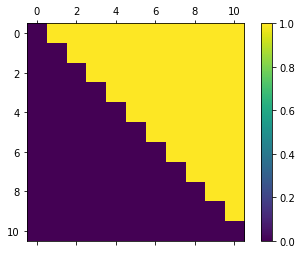

Roll again matrix when opponent is 3 squares away from target


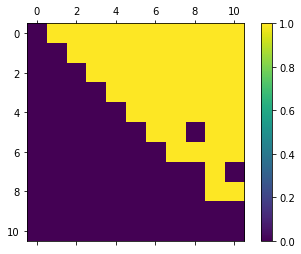

Roll again matrix when opponent is 5 squares away from target


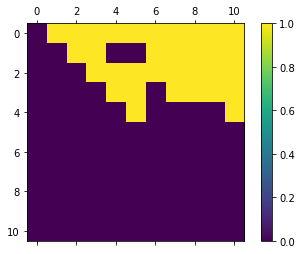

Roll again matrix when opponent is 9 squares away from target


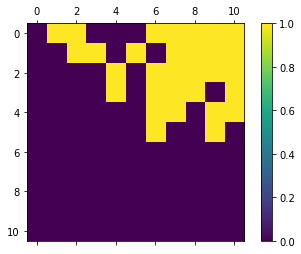

v_star matrix when opponent is 1 square away from target


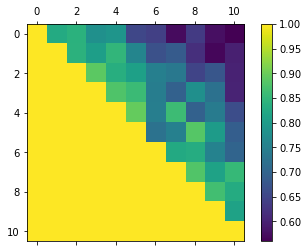

v_star matrix when opponent is 6 square away from target


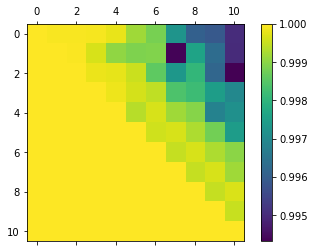

In [ ]:
# when we have 1 turn left, we should try to win
print("Roll again matrix when opponent is 1 squares away from target")
visualizeMatrix(roll_again[:,:,1])

# we should play more aggressive when the opponent
# is closer to the target
print("Roll again matrix when opponent is 3 squares away from target")
visualizeMatrix(roll_again[:,:,3])

# we should play more passive when the opponent
# is further from the target
print("Roll again matrix when opponent is 5 squares away from target")
visualizeMatrix(roll_again[:,:,5])
print("Roll again matrix when opponent is 9 squares away from target")
visualizeMatrix(roll_again[:,:,9])

# the probability to win is very high (> .90) for almost
# every state, except for when the opponent is 1 square
# away from the target. (We have 1 turn to win)
print("v_star matrix when opponent is 1 square away from target")
visualizeMatrix(v_star[:,:,1])
print("v_star matrix when opponent is 6 square away from target")
visualizeMatrix(v_star[:,:,6])

In [ ]:
v_star, roll_again = optimal_strategy_against_enemy(timid_enemy, 10, N_episodes=300000)

Iteration number:  0
Iteration number:  30000
Iteration number:  60000
Iteration number:  90000
Iteration number:  120000
Iteration number:  150000
Iteration number:  180000
Iteration number:  210000
Iteration number:  240000
Iteration number:  270000


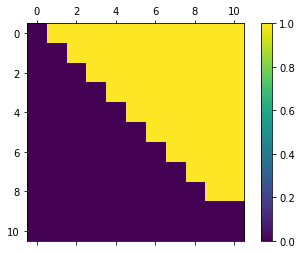

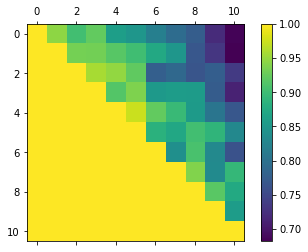

In [ ]:
visualizeMatrix(roll_again[:,:,9])
visualizeMatrix(v_star[:,:,5])